In [27]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
# Harris
def panaroma_rsd(img_rsd1,img_rsd2):
    
    def stitch_rsd(input_img_rsd1, input_img_rsd2):
        
        def corner_rsd(input_img_rsd, b_size = 9, k_size=3, alpha = 0.04):
            # inputs: 
            # input_img_rsd: input grayscale image
            # b_size: block_size for Gaussian filter
            # k_size: k_size for sobel i.e. sobel window size
            # alpha: constant in R 
            # for a grayscale image finds harris corner
            h, w = input_img_rsd.shape[0],input_img_rsd.shape[1]
            
            # derivatives using sobel operator
            der_x = cv2.Sobel(input_img_rsd,cv2.CV_64F,1,0,ksize=k_size)
            der_y = cv2.Sobel(input_img_rsd,cv2.CV_64F,0,1,ksize=k_size)

            # 2nd moment matrix generation
            Ixx = der_x*der_x
            Ixy = der_x*der_y
            Iyy = der_y*der_y
            
            # gaussian kernel size is given by ip b_size

            # Moment matrix M = summation of W(x,y)[[Ix^2 ,IxIy],[IxIy,Iy^2]]
            Ixx = cv2.GaussianBlur(Ixx,(b_size,b_size),0)
            Ixy = cv2.GaussianBlur(Ixy,(b_size,b_size),0)
            Iyy = cv2.GaussianBlur(Iyy,(b_size,b_size),0)
            # r matrix
            r_mat=np.zeros([h,w],dtype=float)
            for i in range(0,h):
                    for j in range(0,w):
                        M = [[Ixx[i,j],Ixy[i,j]],[Ixy[i,j],Iyy[i,j]]]

                        r_mat[i][j] = np.linalg.det(M) - alpha*(np.trace(M)**2)

            # threshold = 10% Rmax
            threshold= 0.01*np.max(r_mat)   
            corners_rsd=[]
            for i in range(h):
                for j in range(w):
                    if r_mat[i][j] >= threshold:
                        corners_rsd.append([i,j]) 
            # returns list with corners coordinates
            return corners_rsd


        def reshape_rsd(image):
            
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # apply binary threshold to grayscale img
            thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

            # Finds contours from the binary image
            _,cnts,_ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cnt = cnts[0]
            
            # boundary elements are found
            x, y, w, h = cv2.boundingRect(cnt)

            # crop the image to the box coordinates
            result = image[y:y + h, x:x + w]
        
            return result
  
        # create SIFT object
        descriptor = cv2.xfeatures2d.SIFT_create()
        
        # for 3d image convert img, convert it to grayscale first 
        if input_img_rsd1.ndim == 3 & input_img_rsd2.ndim == 3:
            input_img_rsd1_gray = cv2.cvtColor(input_img_rsd1, cv2.COLOR_BGR2GRAY)
            input_img_rsd2_gray = cv2.cvtColor(input_img_rsd2, cv2.COLOR_BGR2GRAY)
            
            # calling harris corner function to detect keypoints
            coordinatesA =  corner_rsd(input_img_rsd1_gray,3,3,0.04)
            coordinatesB =  corner_rsd(input_img_rsd2_gray,3,3,0.04)

        else:
            coordinatesA  =  corner_rsd(input_img_rsd1,3,3,0.04)
            coordinatesB =  corner_rsd(input_img_rsd2,3,3,0.04)
        
        key_pointsA=[]
        key_pointsB=[]
        # converting list of coordinates to keypoints
        for p in coordinatesA:
            key_pointsA.append(cv2.KeyPoint(float(p[1]),float(p[0]),10))

        for p in coordinatesB:
            key_pointsB.append(cv2.KeyPoint(float(p[1]),float(p[0]),10))
            
        # computing descriptors and features for custom keypoints
        (featuresA, descriptorsA) = descriptor.compute(input_img_rsd1,key_pointsA)

        (featuresB, descriptorsB) = descriptor.compute(input_img_rsd2,key_pointsB)
        
        # Brute force matcher
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck = True)
        
        # matching descriptors
        best_matches = bf.match(descriptorsA, descriptorsB)
        
        # sorting matches based on distance
        Matches_rsd = sorted(best_matches, key = lambda x:x.distance)

        #img3 = cv2.drawMatches(input_img_rsd1,featuresA,input_img_rsd2,featuresB, Matches_rsd[:100],
                                   #None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

        kpsA = np.float32([kp.pt for kp in featuresA])
        kpsB = np.float32([kp.pt for kp in featuresB])

        if len( Matches_rsd ) > 4:

                # construct the two sets of points
                ptsA = np.float32([kpsA[m.queryIdx] for m in  Matches_rsd ])
                ptsB = np.float32([kpsB[m.trainIdx] for m in  Matches_rsd ])

                # estimate the homography between the sets of points
                (H, status) = cv2.findHomography(ptsB, ptsA, cv2.RANSAC,4)
        
        # H_inv
        xh = np.linalg.inv(H)
        # compensating negative translation 
        f1 = np.dot(xh, np.array([0,0,1]))
        f1 = f1/f1[-1]
        xh[0][-1] += abs(f1[0])
        xh[1][-1] += abs(f1[1])
        # determining offset for img
        ds = np.dot(xh, np.array([input_img_rsd1.shape[1], input_img_rsd1.shape[0], 1]))
        offsety = abs(int(f1[1]))
        offsetx = abs(int(f1[0]))
        dsize = (int(ds[0])+offsetx+input_img_rsd2.shape[0], int(ds[1]) + offsety+input_img_rsd2.shape[1])

        # wrap first img wrt second
        output_rsd = cv2.warpPerspective(input_img_rsd1, xh, dsize)
        # second imag added
        output_rsd[offsety:input_img_rsd2.shape[0]+offsety, offsetx:input_img_rsd2.shape[1]+offsetx] = input_img_rsd2
        
        # resizing image
        output_image_rsd = reshape_rsd(output_rsd)
        
        return output_image_rsd 
    
    try:
        # right stitch
        result=stitch_rsd(img_rsd1,img_rsd2)
    except:
        # left stitch
        result=stitch_rsd(img_rsd2,img_rsd1)
    
    return result

In [29]:
# SIFT
def image_stitch_rsd(img_rsd1,img_rsd2):
    
    def stitch_rsd(input_img_rsd1,input_img_rsd2):
    
        def reshape_rsd(image):
            
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # apply binary threshold to grayscale img
            thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

            # Finds contours from the binary image
            _,cnts,_ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cnt = cnts[0]
            
            # boundary elements are found
            x, y, w, h = cv2.boundingRect(cnt)

            # crop the image to the bbox coordinates
            result = image[y:y + h, x:x + w]
        
            return result

         # create SIFT object
        descriptor = cv2.xfeatures2d.SIFT_create()
        
         #calculating features and descriptors using SIFT
        (featuresA, descriptorsA) = descriptor.detectAndCompute(input_img_rsd1, None)
        (featuresB, descriptorsB) = descriptor.detectAndCompute(input_img_rsd2, None)

        # Brute force matcher
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck = True)
        
        # matching descriptors
        best_matches = bf.match(descriptorsA, descriptorsB)
        
        # sorting matches based on distance
        Matches_rsd = sorted(best_matches, key = lambda x:x.distance)

        #img3 = cv2.drawMatches(input_img_rsd1,featuresA,input_img_rsd2,featuresB, Matches_rsd[:100],
                                   #None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

        kpsA = np.float32([kp.pt for kp in featuresA])
        kpsB = np.float32([kp.pt for kp in featuresB])

        if len( Matches_rsd ) > 4:

                # construct the two sets of points
                ptsA = np.float32([kpsA[m.queryIdx] for m in  Matches_rsd ])
                ptsB = np.float32([kpsB[m.trainIdx] for m in  Matches_rsd ])

                # estimate the homography between the sets of points
                (H, status) = cv2.findHomography(ptsB, ptsA, cv2.RANSAC,4)
   
        # H_inv
        xh = np.linalg.inv(H)
        # compensating negative translation 
        f1 = np.dot(xh, np.array([0,0,1]))
        f1 = f1/f1[-1]
        xh[0][-1] += abs(f1[0])
        xh[1][-1] += abs(f1[1])
        # determining offset for img
        ds = np.dot(xh, np.array([input_img_rsd1.shape[1], input_img_rsd1.shape[0], 1]))
        offsety = abs(int(f1[1]))
        offsetx = abs(int(f1[0]))
        dsize = (int(ds[0])+offsetx+input_img_rsd2.shape[0], int(ds[1]) + offsety+input_img_rsd2.shape[1])

        # wrap first img wrt second
        output_rsd = cv2.warpPerspective(input_img_rsd1, xh, dsize)
        # second imag added
        output_rsd[offsety:input_img_rsd2.shape[0]+offsety, offsetx:input_img_rsd2.shape[1]+offsetx] = input_img_rsd2
        
        # resizing image
        output_image_rsd = reshape_rsd(output_rsd)
        
        return output_image_rsd 
    
    try:
        # right stitch
        result=stitch_rsd(img_rsd1,img_rsd2)
    except:
        # left stitch
        result=stitch_rsd(img_rsd2,img_rsd1)
    
    return result

In [30]:
#Random order of sequence

def random_rsd(image_list, sequence = int(0), sift = int(1)):
    
    ## inputs:
    ## image_list: list of images
    ## sequence = 1 indicates given images are given in sequence
    ## sift = 1 indicates output needed using sift algo
    ## sift = 0 indicates op needed using harris corner algo
    
    def matches_rsd(img_1, img_2):
        # function that gives no. of matches
        
        descriptor = cv2.xfeatures2d.SIFT_create()
        (featureA, descriptorsA) = descriptor.detectAndCompute(img_1, None)
        (featureB, descriptorsB) = descriptor.detectAndCompute(img_2, None)

        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck = True)

        best_matches = bf.match(descriptorsA, descriptorsB)

        Matches_rsd = sorted(best_matches, key = lambda x:x.distance)

        return len(Matches_rsd)
   
    def stitch_rand_rsd(images_list, sift):
        # considering 1 img initially
        img1 = images_list[0]
        M = []
        new_images_list = []
        for i in range(1, len(images_list)):
            # find matches
            value =  matches_rsd(img1, images_list[i])
            M.append([value,i])
       
        # find max no. of matches between img1 and some image
        Maxim = max(M)
        if sift:    
            # op using sift
            output = image_stitch_rsd(img1, images_list[Maxim[1]])
        else:
            # op using harris
            output = panaroma_rsd(img1, images_list[Maxim[1]])
        L =[output] 
        
        # pop out the 2 used images
        images_list.pop(Maxim[1])
        images_list.pop(0)
        
        # append the new stitched img
        new_images_list = L + images_list
        
        # returns new img ist with 1st img as stitched img and remaining imgs
        return new_images_list
    
    ## if sequence is given and sift op is needed
    if sequence & sift:
        for i in range(len(image_list)-1):
            output = image_stitch_rsd(image_list[i], image_list[i+1])
            image_list[i+1] = output        
        return output
    
    ## if sequence is given and harris op is needed
    elif sequence & ~(sift):
        for i in range(len(image_list)-1):
            output = panaroma_rsd(image_list[i], image_list[i+1])
            image_list[i+1] = output
        return output
    
    # if random sequence is given
    else:
        while len(image_list) > 1:
            image_list = stitch_rand_rsd(image_list, sift)
        return image_list[0]
            

Text(0.5, 1.0, 'Panaroma')

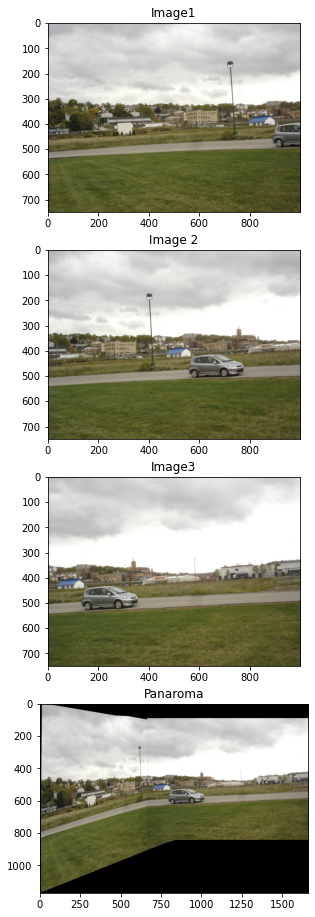

In [32]:
img1 = cv2.imread("car1.jpg")
img2 = cv2.imread("car2.jpg")
img3 = cv2.imread("car3.jpg")
#img4 = cv2.imread("m4.jpg")
#img5 = cv2.imread("m5.jpg")

images = [img2, img1, img3]

seq = int(1)
sift = int(1)
final =  random_rsd(images, seq, sift)

plt.figure(figsize=(20,16))
plt.subplot(4,1,1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Image1')
plt.subplot(4,1,2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('Image 2')
plt.subplot(4,1,3)
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
plt.title("Image3")
plt.subplot(4,1,4)
plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))
plt.title('Panaroma')


#cv2.imshow(",Warp result", final)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
#cv2.imwrite("car_op.png",final)

In [25]:
cv2.__version__


'3.4.11'

In [26]:
np.__version__

'1.19.2'